In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
from transformers import ViTFeatureExtractor, ViTForImageClassification
from sklearn.metrics import classification_report , confusion_matrix
import itertools
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
from utils import *
from grad_cam import *
import io
from PIL import Image as PILImage
import random


In [2]:
def apply_train_transforms(image):
    train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    return train_transform(image)

In [3]:
def apply_test_valid_transforms(image):
    val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    return val_test_transform(image)

In [4]:
def train_collate_fn(batch):
    transformed_images = []
    labels = []
    for image, label in batch:
        transformed_image = apply_train_transforms(image)
        transformed_images.append(transformed_image)
        labels.append(label)
    return torch.stack(transformed_images), torch.tensor(labels)

In [5]:
def test_valid_collate_fn(batch):
    transformed_images = []
    labels = []
    for image, label in batch:
        transformed_image = apply_test_valid_transforms(image)
        transformed_images.append(transformed_image)
        labels.append(label)
    return torch.stack(transformed_images), torch.tensor(labels)

In [6]:
data_dir = "C:/Users/Jan/SGH/magisterka/dane/kvasir-dataset-v2/dane"

### Transformacje dla poszczególnych zbiorów

In [7]:
ds = datasets.ImageFolder(data_dir)

In [8]:
class_names = ds.classes
class_names

['dyed-lifted-polyps',
 'dyed-resection-margins',
 'esophagitis',
 'normal-cecum',
 'normal-pylorus',
 'normal-z-line',
 'polyps',
 'ulcerative-colitis']

In [9]:
custom_labels = {i: name for i, name in enumerate(class_names)}
custom_labels

{0: 'dyed-lifted-polyps',
 1: 'dyed-resection-margins',
 2: 'esophagitis',
 3: 'normal-cecum',
 4: 'normal-pylorus',
 5: 'normal-z-line',
 6: 'polyps',
 7: 'ulcerative-colitis'}

In [10]:
train_size = int(0.8 * len(ds))
valid_size = int(0.1 * len(ds))
test_size = len(ds) - train_size - valid_size

train_dataset, valid_dataset, test_dataset = random_split(ds, [train_size, valid_size, test_size])

In [11]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=train_collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=test_valid_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=test_valid_collate_fn)

### Ładowanie pre-wytrenowanego modelu

In [12]:
# Load the pre-trained ViT model
model_name = "google/vit-base-patch16-224-in21k"
feature_extractor = ViTFeatureExtractor(model_name)
model = ViTForImageClassification.from_pretrained(model_name, num_labels=len(ds.classes))

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Definiowanie funkcji straty oraz optymizer

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001)

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001, total_steps=len(train_loader) * 20)

In [14]:
num_epochs = 50

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [16]:
model, model_history = train_and_validate(model, train_loader, valid_loader, criterion, optimizer, scheduler, num_epochs, device, "C:/Users/Jan/SGH/magisterka/repo/praca_magisterska/ViT_hugging_face/", "vit-pytorch-ksavir-half-best-model.pth")

Najlepszy model został zapisany do C:/Users/Jan/SGH/magisterka/repo/praca_magisterska/ViT_hugging_face/vit-pytorch-ksavir-half-best-model.pth
Epoch [1/50] Train Loss: 1.0453, Train Accuracy: 71.25% Val Loss: 0.4929, Val Accuracy: 88.75% Czas trwania epoki: 179.92s
Najlepszy model został zapisany do C:/Users/Jan/SGH/magisterka/repo/praca_magisterska/ViT_hugging_face/vit-pytorch-ksavir-half-best-model.pth
Epoch [2/50] Train Loss: 0.4971, Train Accuracy: 84.52% Val Loss: 0.3147, Val Accuracy: 91.75% Czas trwania epoki: 165.20s
Epoch [3/50] Train Loss: 0.3867, Train Accuracy: 87.27% Val Loss: 0.3009, Val Accuracy: 90.12% Czas trwania epoki: 163.01s
Epoch [4/50] Train Loss: 0.3560, Train Accuracy: 87.53% Val Loss: 0.2581, Val Accuracy: 91.12% Czas trwania epoki: 164.81s
Najlepszy model został zapisany do C:/Users/Jan/SGH/magisterka/repo/praca_magisterska/ViT_hugging_face/vit-pytorch-ksavir-half-best-model.pth
Epoch [5/50] Train Loss: 0.3044, Train Accuracy: 89.73% Val Loss: 0.2122, Val Accu

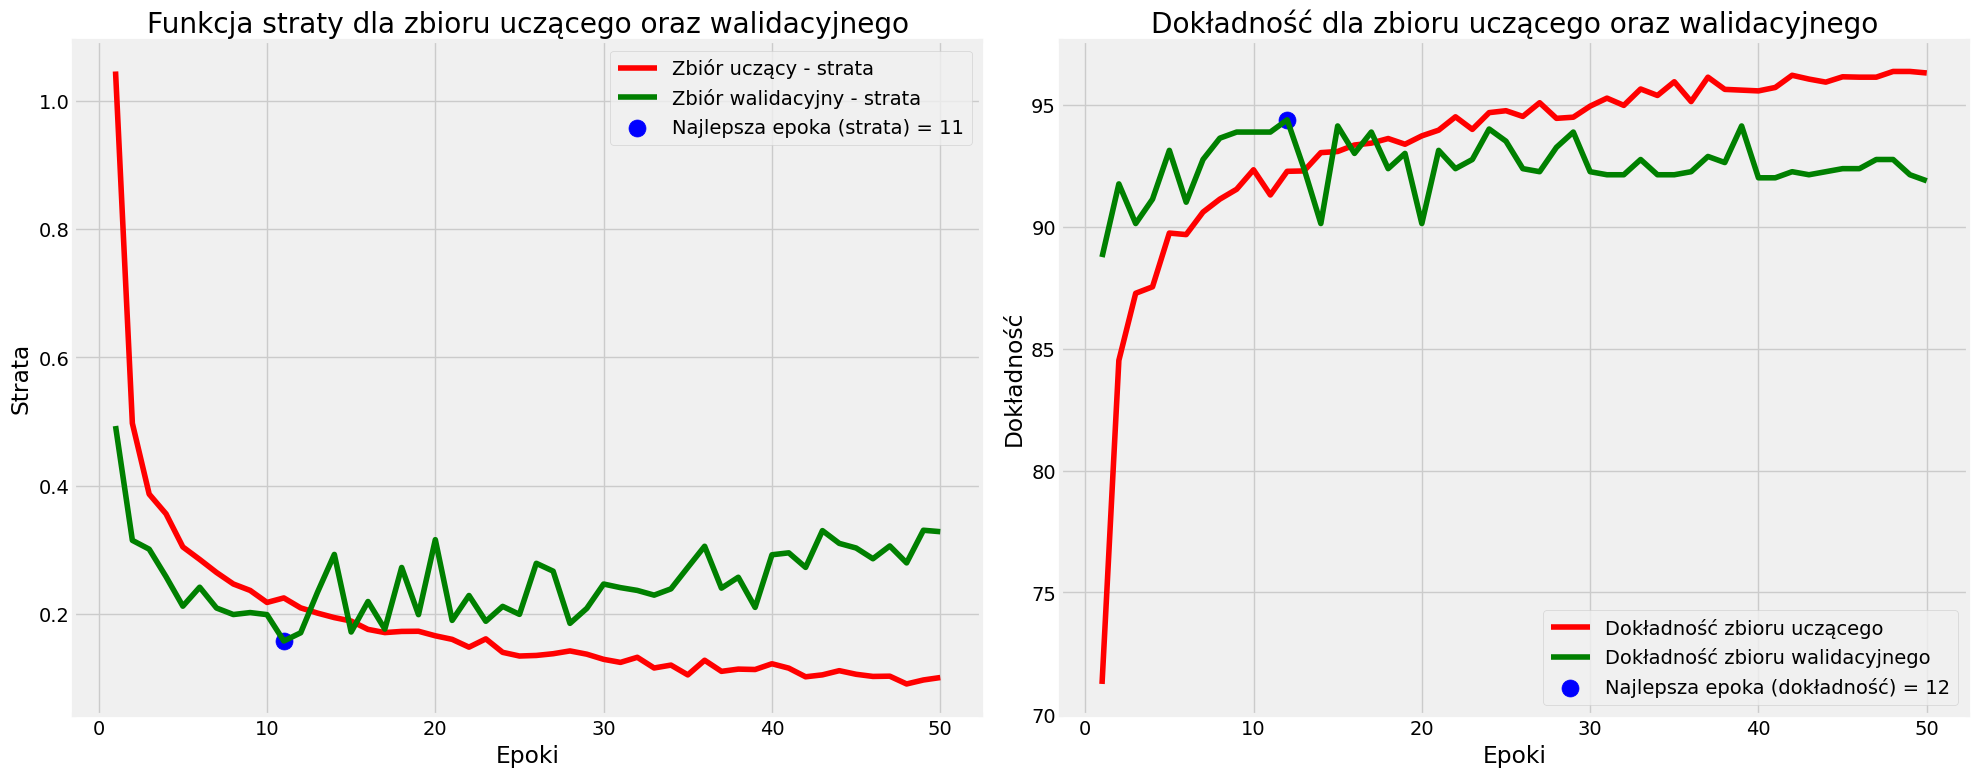

In [17]:
show_loss_accuracy_plots(model_history)

### Testowanie modelu

In [18]:
model.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.logits, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = 100 * test_correct / test_total
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 92.25%


In [19]:
evaluate_model(model, test_loader, device)

                        precision    recall  f1-score   support

    dyed-lifted-polyps       0.92      0.96      0.94        97
dyed-resection-margins       0.96      0.95      0.96       102
           esophagitis       0.95      0.73      0.83       114
          normal-cecum       0.96      0.94      0.95        85
        normal-pylorus       0.96      0.99      0.98       104
         normal-z-line       0.75      0.93      0.83        92
                polyps       0.91      0.99      0.95       100
    ulcerative-colitis       0.99      0.92      0.95       106

              accuracy                           0.92       800
             macro avg       0.93      0.93      0.92       800
          weighted avg       0.93      0.92      0.92       800



In [20]:
test_predictions, test_labels = get_predictions_and_labels(model, test_loader, device)

In [21]:
cm_test = confusion_matrix(test_labels, test_predictions)

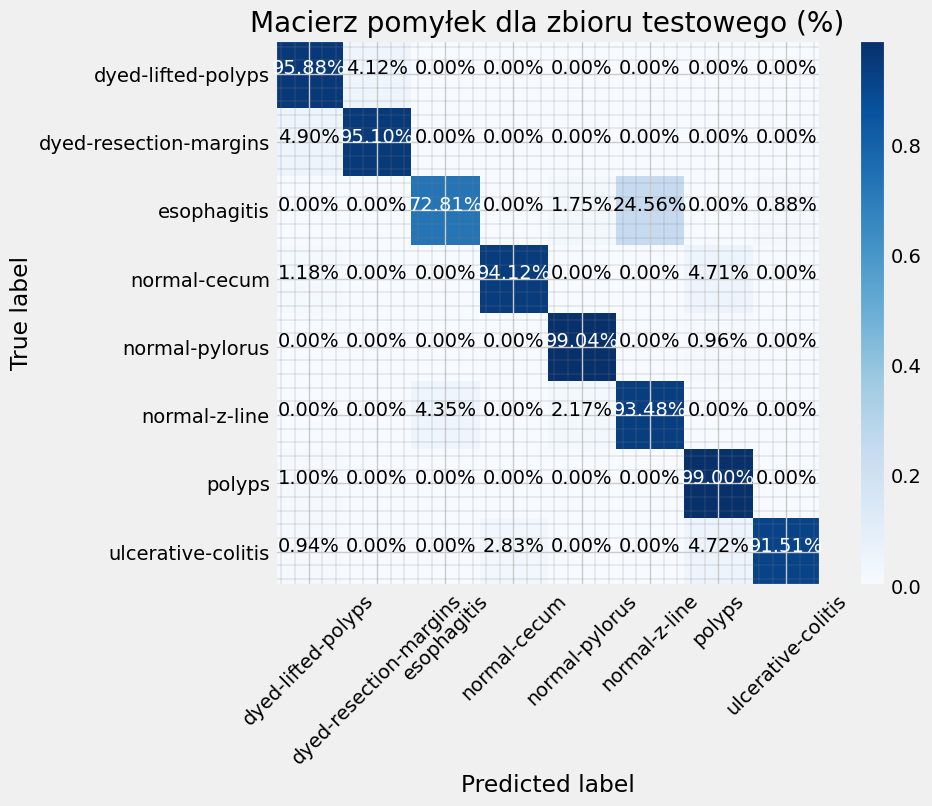

In [22]:
plot_confusion_matrix_percent(cm_test, class_names, 'Macierz pomyłek dla zbioru testowego (%)')

Label: dyed-lifted-polyps


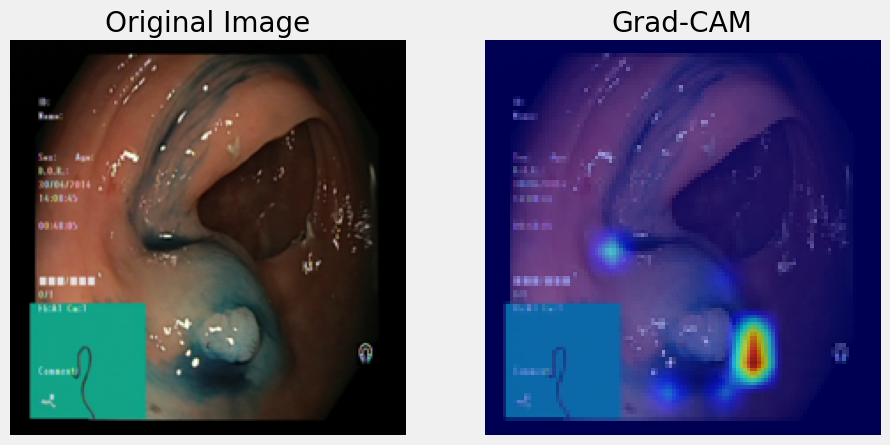

Label: dyed-resection-margins


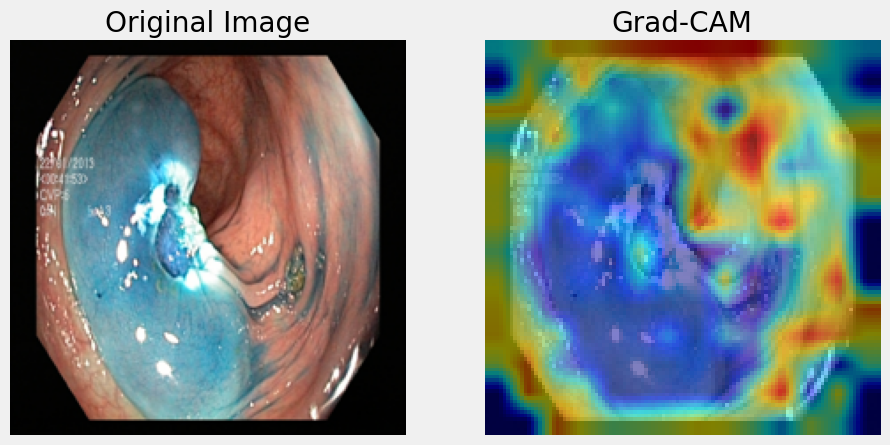

Label: esophagitis


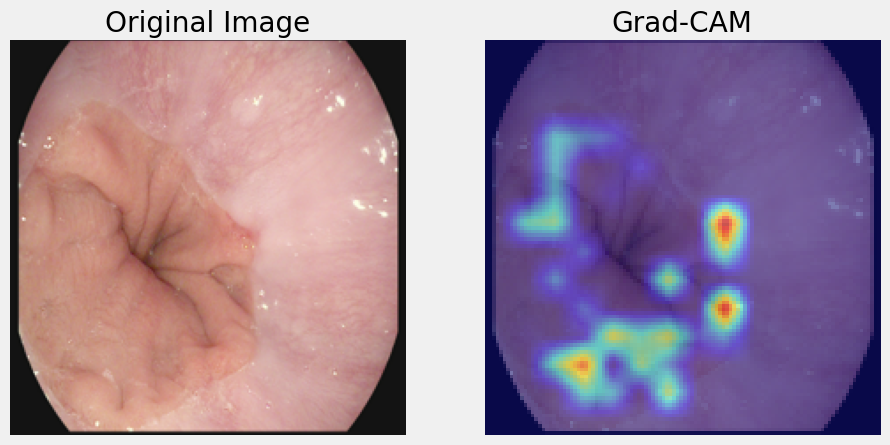

Label: normal-cecum


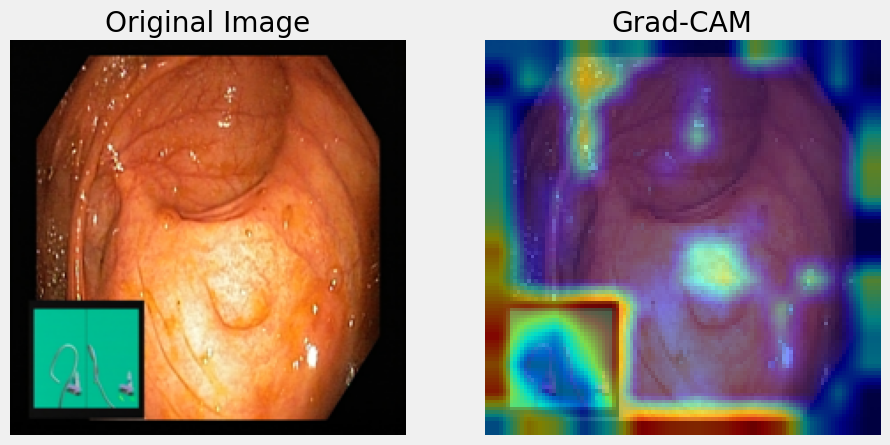

Label: normal-pylorus


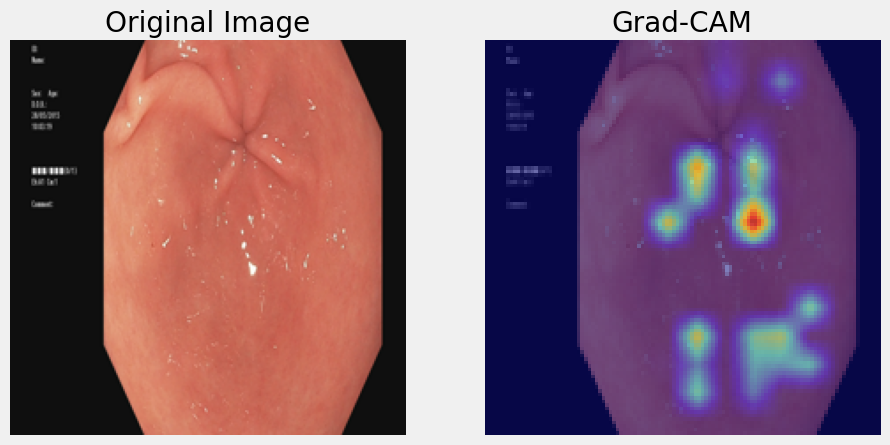

Label: normal-z-line


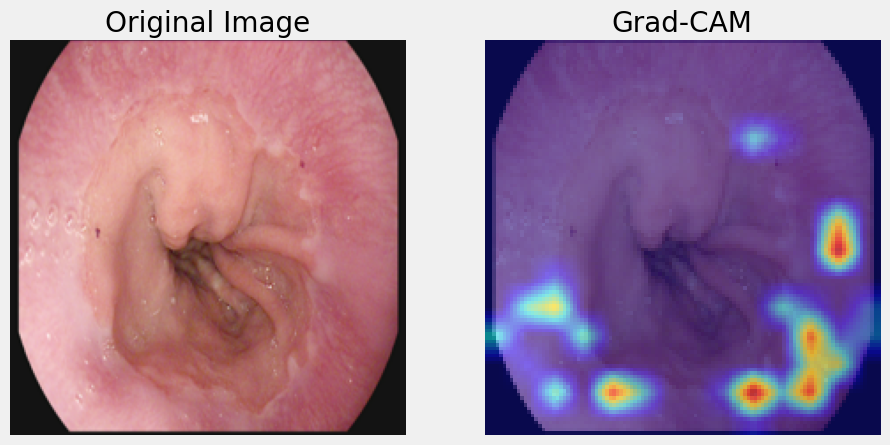

Label: polyps


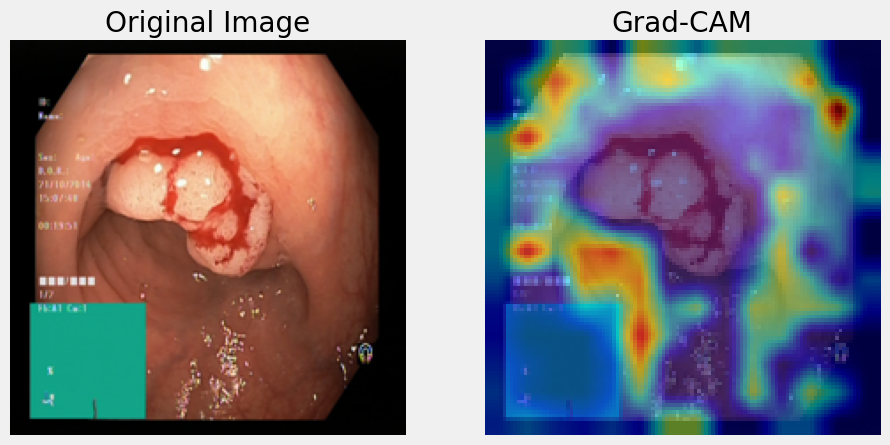

Label: ulcerative-colitis


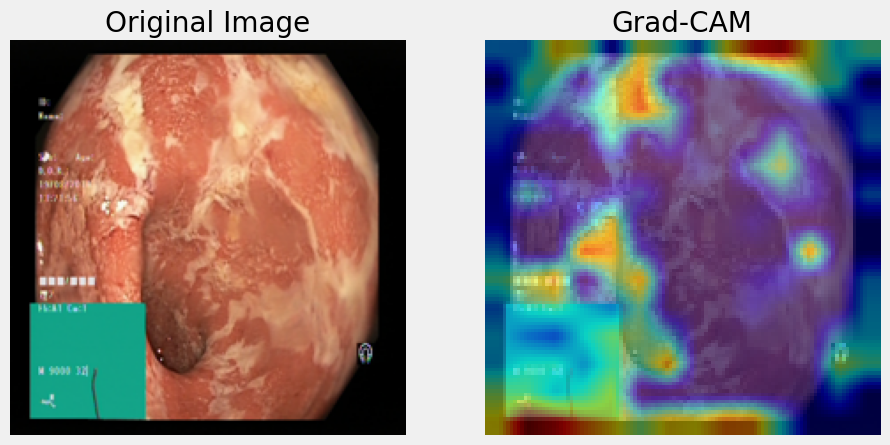

In [23]:
# display_images_with_gradcam(model=model, dataset = train_dataset, reshape_transform = reshape_transform_vit_huggingface, custom_labels = custom_labels, num_classes = len(class_names))

In [48]:
class HuggingfaceToTensorModelWrapper(torch.nn.Module):
    def __init__(self, model):
        super(HuggingfaceToTensorModelWrapper, self).__init__()
        self.model = model

    def forward(self, x):
        return self.model(x).logits


""" Translate the category name to the category index.
    Some models aren't trained on Imagenet but on even larger datasets,
    so we can't just assume that 761 will always be remote-control.

"""


def category_name_to_index(model, category_name):
    name_to_index = dict((v, k) for k, v in model.config.id2label.items())
    return name_to_index[category_name]


""" Helper function to run GradCAM on an image and create a visualization.
    (note to myself: this is probably useful enough to move into the package)
    If several targets are passed in targets_for_gradcam,
    e.g different categories,
    a visualization for each of them will be created.

"""


def run_grad_cam_on_image(model: torch.nn.Module,
                          target_layer: torch.nn.Module,
                          targets_for_gradcam: List[Callable],
                          reshape_transform: Optional[Callable],
                          input_tensor: torch.nn.Module,
                          input_image: Image,
                          method: Callable = GradCAM):
    with method(model=HuggingfaceToTensorModelWrapper(model),
                target_layers=[target_layer],
                reshape_transform=reshape_transform) as cam:
        # Replicate the tensor for each of the categories we want to create Grad-CAM for:
        repeated_tensor = input_tensor[None, :].repeat(len(targets_for_gradcam), 1, 1, 1)

        batch_results = cam(input_tensor=repeated_tensor,
                            targets=targets_for_gradcam)
        results = []
        for grayscale_cam in batch_results:
            visualization = show_cam_on_image(np.float32(input_image) / 255,
                                              grayscale_cam,
                                              use_rgb=True)
            # Make it weight less in the notebook:
            visualization = cv2.resize(visualization,
                                       (visualization.shape[1] // 2, visualization.shape[0] // 2))
            results.append(visualization)
        return np.hstack(results)


def print_top_categories(model, img_tensor, top_k=5):
    logits = model(img_tensor.unsqueeze(0)).logits
    indices = logits.cpu()[0, :].detach().numpy().argsort()[-top_k:][::-1]
    for i in indices:
        print(f"Predicted class {i}: {model.config.id2label[i]}")

def reshape_transform_vit_huggingface(x, img_size=224, patch_size=16):

    # Obliczenie liczby łatek na bok obrazu
    n_patches_side = img_size // patch_size

    # Pomijamy token klasy i zmieniamy kształt
    activations = x[:, 1:, :]
    activations = activations.view(activations.shape[0],
                                   n_patches_side, n_patches_side,
                                   activations.shape[2])

    # Transpozycja do formatu CHW
    activations = activations.transpose(2, 3).transpose(1, 2)
    return activations

def display_images_with_gradcam(model, dataset, reshape_transform, num_classes, method, image_size=(224, 224),
                                custom_labels=None):
    # Automatyczne określenie warstwy docelowej dla Grad-CAM
    target_layer_gradcam = model.vit.encoder.layer[-2].output

    # Iteracja przez klasy i wybór losowego obrazu dla każdej klasy
    for class_id in range(num_classes):
        # Zbierz wszystkie obrazy należące do aktualnej klasy
        class_images = [(image, label) for image, label in dataset if label == class_id]

        # Jeśli nie ma obrazów dla klasy, kontynuuj pętlę
        if not class_images:
            continue

        # Wybierz losowy obraz dla klasy
        image, label = random.choice(class_images)

        # Przeskaluj obraz do odpowiedniego rozmiaru
        image_resized = image.resize(image_size)
        tensor_resized = transforms.ToTensor()(image_resized)

        # Ustawienie celów dla Grad-CAM
        targets_for_gradcam = [ClassifierOutputTarget(class_id)]

        # Uruchomienie Grad-CAM
        grad_cam_result = run_grad_cam_on_image(model=model,
                                                target_layer=target_layer_gradcam,
                                                targets_for_gradcam=targets_for_gradcam,
                                                input_tensor=tensor_resized,
                                                input_image=image_resized,
                                                reshape_transform=reshape_transform,
                                                method=method)

        buffer_grad_cam = io.BytesIO()
        PILImage.fromarray(grad_cam_result).save(buffer_grad_cam, format='PNG')
        buffer_grad_cam.seek(0)

        display_label = custom_labels[label] if custom_labels else label
        print(f"Label: {display_label}")
        fig, ax = plt.subplots(1, 2, figsize=(10, 5))
        ax[0].imshow(image_resized)
        ax[0].axis('off')
        ax[0].set_title('Original Image')

        ax[1].imshow(PILImage.open(buffer_grad_cam))
        ax[1].axis('off')
        ax[1].set_title(f'{method}')

        plt.show()

100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:02<00:00, 17.87it/s]


Label: dyed-lifted-polyps


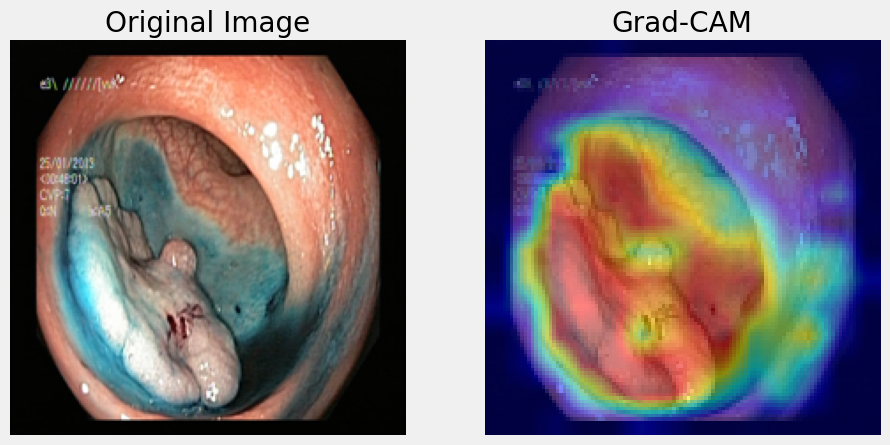

100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:02<00:00, 18.54it/s]


Label: dyed-resection-margins


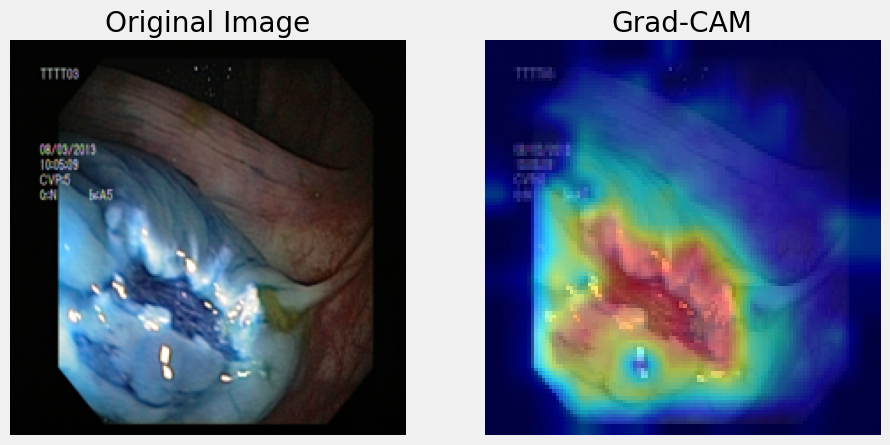

100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:02<00:00, 17.83it/s]


Label: esophagitis


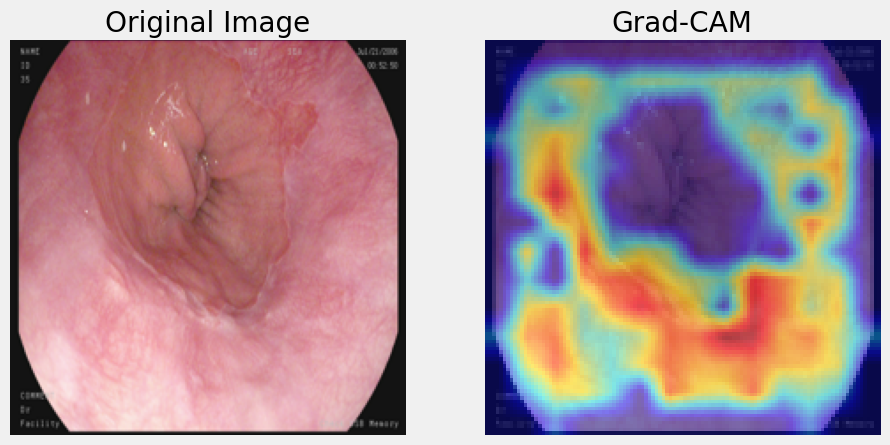

100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:02<00:00, 17.42it/s]


Label: normal-cecum


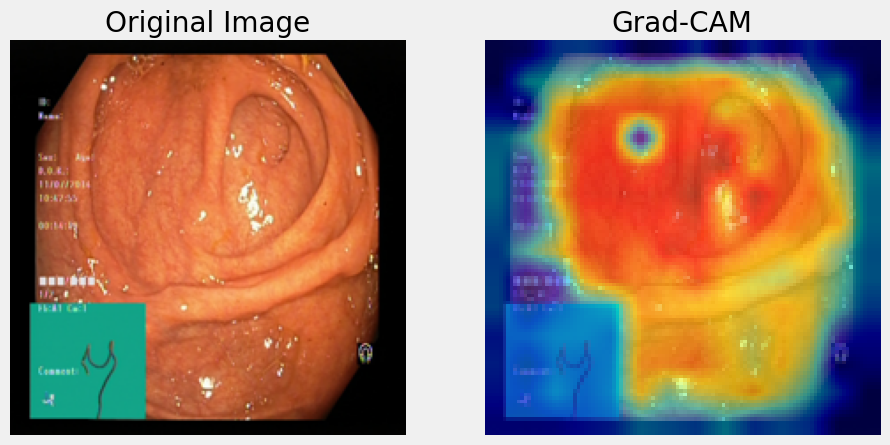

100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:02<00:00, 17.50it/s]


Label: normal-pylorus


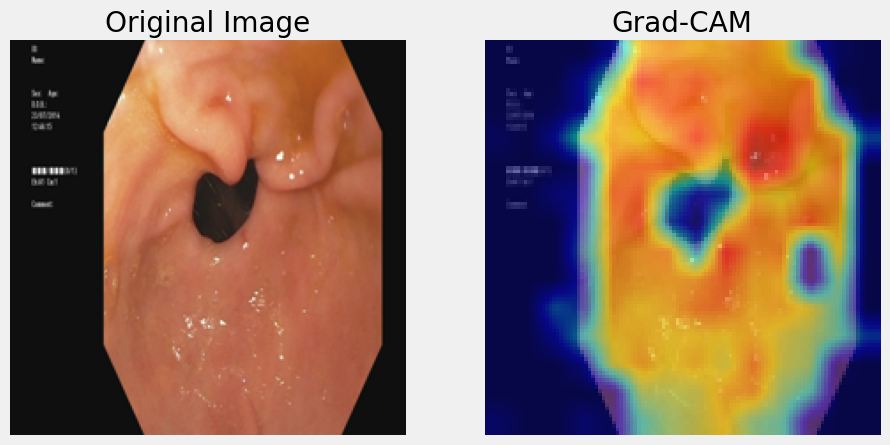

100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:02<00:00, 18.70it/s]


Label: normal-z-line


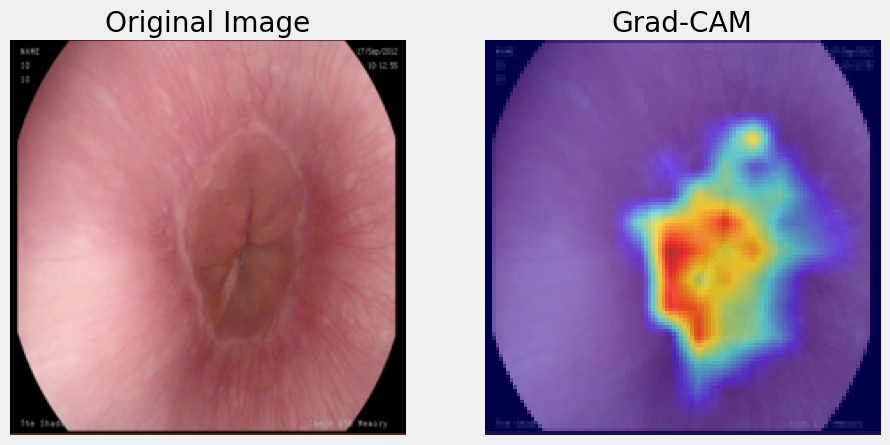

100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:02<00:00, 18.46it/s]


Label: polyps


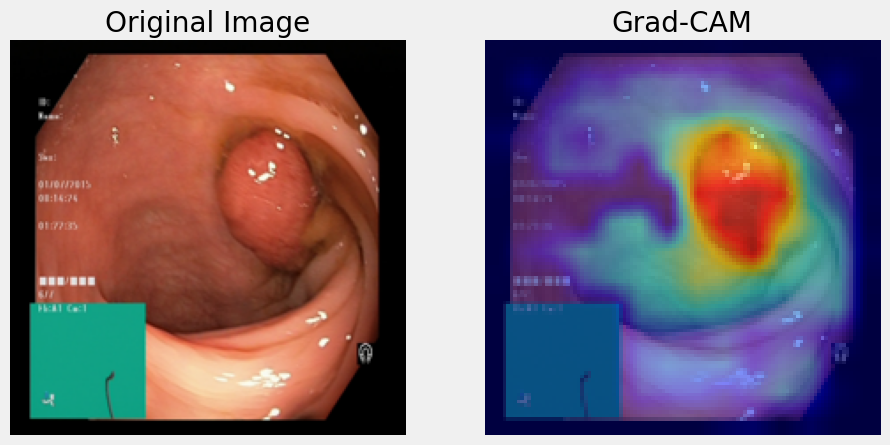

100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:02<00:00, 17.85it/s]


Label: ulcerative-colitis


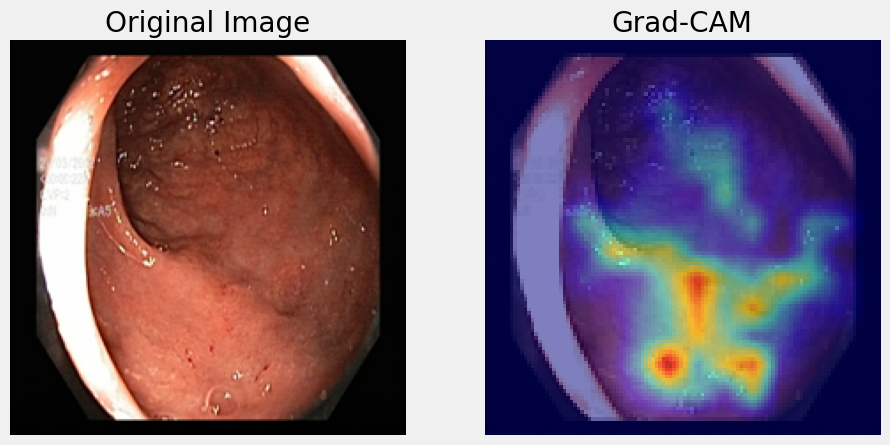

In [49]:
display_images_with_gradcam(model=model, dataset = train_dataset, reshape_transform = reshape_transform_vit_huggingface, custom_labels = custom_labels, num_classes = len(class_names), method=ScoreCAM)